# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [21:56<00:00, 45.6File/s]  


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

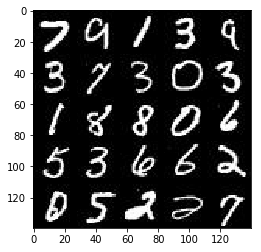

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

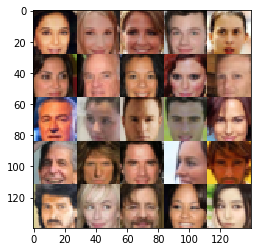

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, stddev=0.02):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 in: 7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)

    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))    

    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 1.6429
Epoch 1/2... Discriminator Loss: 2.2713... Generator Loss: 0.1631
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 1.1904
Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 3.8711
Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 5.8946
Epoch 1/2... Discriminator Loss: 0.5493... Generator Loss: 1.9000
Epoch 1/2... Discriminator Loss: 0.3673... Generator Loss: 3.7074
Epoch 1/2... Discriminator Loss: 0.4949... Generator Loss: 2.1910
Epoch 1/2... Discriminator Loss: 0.4178... Generator Loss: 5.4546
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 1.7249


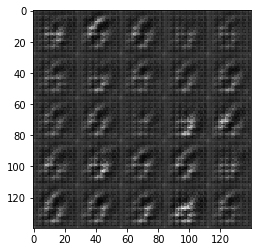

Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 1.3466
Epoch 1/2... Discriminator Loss: 0.6920... Generator Loss: 1.7573
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 1.1984
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 2.0402
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 1.3777
Epoch 1/2... Discriminator Loss: 0.7717... Generator Loss: 2.8567
Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 1.8723... Generator Loss: 3.9190


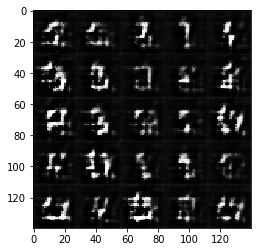

Epoch 1/2... Discriminator Loss: 0.8434... Generator Loss: 2.0279
Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 2.4073
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 0.4634
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 1.3037
Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 1.4130
Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 0.9806
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.2091


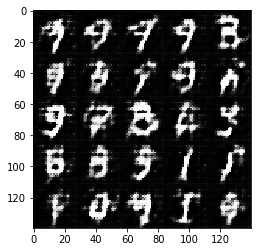

Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.6284
Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 1.3168
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 0.7695
Epoch 1/2... Discriminator Loss: 0.7658... Generator Loss: 1.7894
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.4928
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.8188
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 1.4375
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 0.9794
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 1.2019


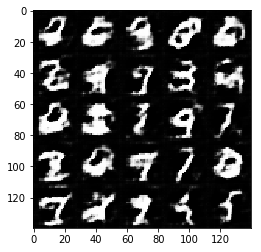

Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 0.8601
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.6341
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 1.7461
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.7357
Epoch 1/2... Discriminator Loss: 1.6151... Generator Loss: 0.3649
Epoch 1/2... Discriminator Loss: 1.6996... Generator Loss: 0.3167
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 1.5383... Generator Loss: 0.4172
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.6737


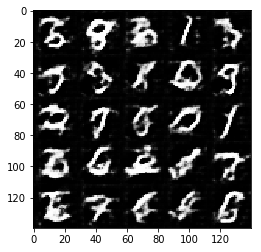

Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.6025
Epoch 1/2... Discriminator Loss: 1.7827... Generator Loss: 0.3087
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.6520
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.9333
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 1.6835... Generator Loss: 0.3570
Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 0.4104
Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 0.9313


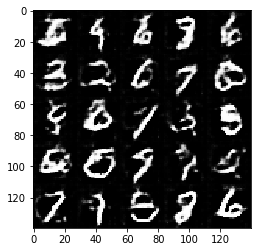

Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.0273... Generator Loss: 0.9623
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 1.4647... Generator Loss: 0.4686
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.5774... Generator Loss: 0.3777
Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 0.5167
Epoch 1/2... Discriminator Loss: 0.9886... Generator Loss: 1.5235
Epoch 1/2... Discriminator Loss: 0.7669... Generator Loss: 1.7044
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 0.4627


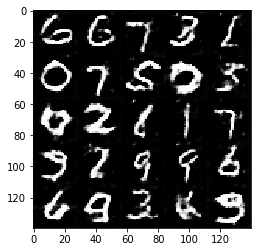

Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 1.1818
Epoch 1/2... Discriminator Loss: 2.4924... Generator Loss: 0.1462
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 1.2759
Epoch 1/2... Discriminator Loss: 1.1531... Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 1.1643
Epoch 1/2... Discriminator Loss: 1.1152... Generator Loss: 1.0317
Epoch 1/2... Discriminator Loss: 1.6640... Generator Loss: 0.3799
Epoch 1/2... Discriminator Loss: 0.9384... Generator Loss: 1.0331


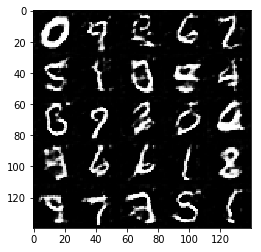

Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.5583
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 1.3465... Generator Loss: 2.0661
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 2.0554... Generator Loss: 0.2368
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 1.1151
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 2.1858


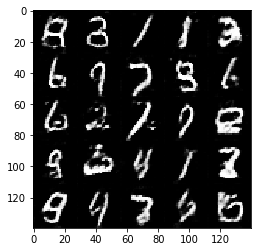

Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.4456
Epoch 1/2... Discriminator Loss: 2.1140... Generator Loss: 0.2109
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 1.6354
Epoch 1/2... Discriminator Loss: 0.8950... Generator Loss: 1.1677
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.5526
Epoch 1/2... Discriminator Loss: 0.8606... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 1.5294... Generator Loss: 0.4184
Epoch 1/2... Discriminator Loss: 1.2080... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.9422... Generator Loss: 0.2537


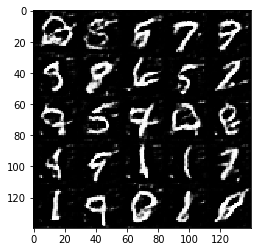

Epoch 1/2... Discriminator Loss: 0.8991... Generator Loss: 1.1467
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 1.0416
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.5657
Epoch 1/2... Discriminator Loss: 1.6441... Generator Loss: 1.5746
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 1.8388
Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 1.7505... Generator Loss: 0.3221
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.8564


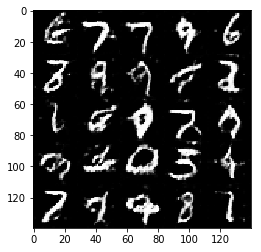

Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 1.1921
Epoch 1/2... Discriminator Loss: 1.7172... Generator Loss: 0.3012
Epoch 1/2... Discriminator Loss: 1.7135... Generator Loss: 0.3801
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.1999
Epoch 1/2... Discriminator Loss: 1.4629... Generator Loss: 0.4934
Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 0.8942... Generator Loss: 1.3661
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 0.8345


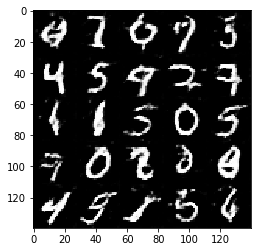

Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 1.0144... Generator Loss: 0.8932
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.4446
Epoch 1/2... Discriminator Loss: 0.8928... Generator Loss: 1.4078
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 1.8402... Generator Loss: 0.2727
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 1.5849
Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 1.6910
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.6293
Epoch 1/2... Discriminator Loss: 0.9213... Generator Loss: 0.8978


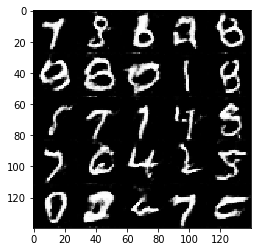

Epoch 1/2... Discriminator Loss: 1.8552... Generator Loss: 0.2702
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.7820
Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.4258
Epoch 1/2... Discriminator Loss: 1.5311... Generator Loss: 0.4352
Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.5449
Epoch 1/2... Discriminator Loss: 1.8694... Generator Loss: 0.3070
Epoch 1/2... Discriminator Loss: 1.4829... Generator Loss: 0.4693
Epoch 1/2... Discriminator Loss: 1.6743... Generator Loss: 0.3244
Epoch 1/2... Discriminator Loss: 0.7057... Generator Loss: 1.3478
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 1.0852


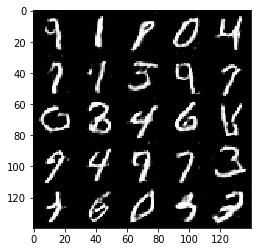

Epoch 1/2... Discriminator Loss: 1.0330... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.1112... Generator Loss: 0.9888
Epoch 1/2... Discriminator Loss: 1.6709... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 1.9959... Generator Loss: 0.2470
Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.4550
Epoch 1/2... Discriminator Loss: 1.6652... Generator Loss: 0.3283
Epoch 1/2... Discriminator Loss: 1.8931... Generator Loss: 0.2511
Epoch 1/2... Discriminator Loss: 1.9869... Generator Loss: 0.2267
Epoch 1/2... Discriminator Loss: 1.6531... Generator Loss: 0.3347
Epoch 1/2... Discriminator Loss: 1.7820... Generator Loss: 0.2981


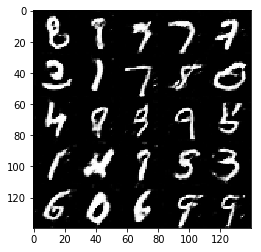

Epoch 1/2... Discriminator Loss: 1.1942... Generator Loss: 0.6175
Epoch 1/2... Discriminator Loss: 1.5822... Generator Loss: 0.3620
Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 0.9505
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.4847
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.0492
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 1.6179... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.7976


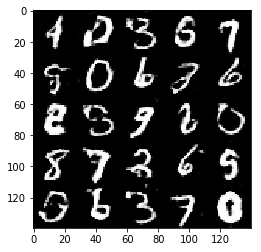

Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 0.6201
Epoch 1/2... Discriminator Loss: 1.8072... Generator Loss: 0.3035
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.6690
Epoch 1/2... Discriminator Loss: 1.6539... Generator Loss: 0.3622
Epoch 1/2... Discriminator Loss: 1.5187... Generator Loss: 0.3917


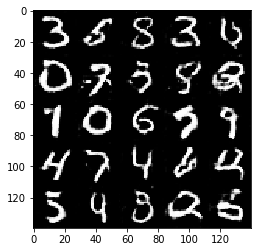

Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.4784
Epoch 1/2... Discriminator Loss: 2.1176... Generator Loss: 0.2349
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 1.0361
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.7047
Epoch 1/2... Discriminator Loss: 2.7548... Generator Loss: 0.1106
Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 1.1448
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 1.1532
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 1.2797


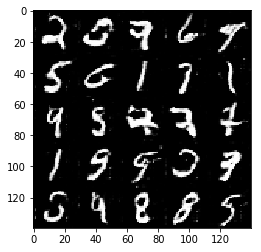

Epoch 1/2... Discriminator Loss: 1.4792... Generator Loss: 0.4527
Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 0.8152... Generator Loss: 1.3596
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.2073... Generator Loss: 0.6092
Epoch 2/2... Discriminator Loss: 1.5903... Generator Loss: 0.3640
Epoch 2/2... Discriminator Loss: 1.8415... Generator Loss: 0.2828
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 0.6454


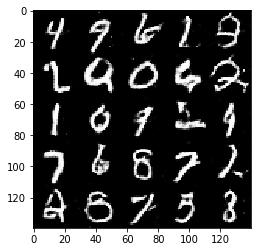

Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 0.9515
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 1.6019
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 1.2195
Epoch 2/2... Discriminator Loss: 1.0401... Generator Loss: 0.7332
Epoch 2/2... Discriminator Loss: 1.5228... Generator Loss: 0.4656
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.6495... Generator Loss: 0.3307
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 1.5420
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 2.2065... Generator Loss: 0.2091


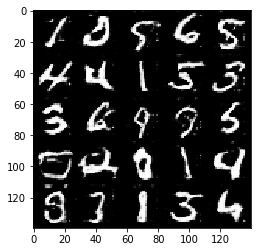

Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 0.9596
Epoch 2/2... Discriminator Loss: 1.0885... Generator Loss: 0.7574
Epoch 2/2... Discriminator Loss: 0.5448... Generator Loss: 2.2925
Epoch 2/2... Discriminator Loss: 1.8967... Generator Loss: 0.2524
Epoch 2/2... Discriminator Loss: 1.0241... Generator Loss: 1.0289
Epoch 2/2... Discriminator Loss: 1.7839... Generator Loss: 0.3174
Epoch 2/2... Discriminator Loss: 0.8284... Generator Loss: 1.0226
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.6002


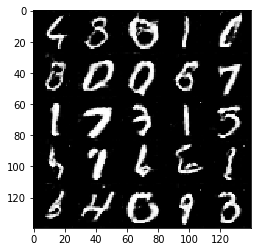

Epoch 2/2... Discriminator Loss: 1.4675... Generator Loss: 0.4287
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.5791
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 1.5427... Generator Loss: 0.3925
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 1.4588
Epoch 2/2... Discriminator Loss: 1.6892... Generator Loss: 1.8958
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 0.5280


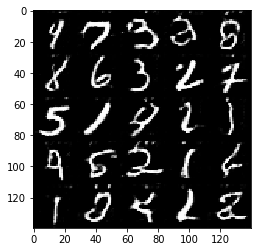

Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 0.4541
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 1.6014
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 1.5310... Generator Loss: 0.3937
Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 0.7211
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.3989
Epoch 2/2... Discriminator Loss: 2.2273... Generator Loss: 0.1958
Epoch 2/2... Discriminator Loss: 1.7363... Generator Loss: 0.3239


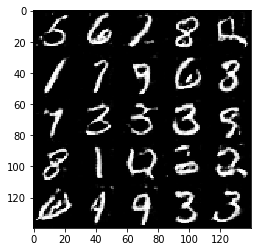

Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.6385
Epoch 2/2... Discriminator Loss: 0.6041... Generator Loss: 1.6804
Epoch 2/2... Discriminator Loss: 1.9756... Generator Loss: 0.2559
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.2256
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 1.2575
Epoch 2/2... Discriminator Loss: 0.7070... Generator Loss: 1.6264
Epoch 2/2... Discriminator Loss: 1.1746... Generator Loss: 1.2401
Epoch 2/2... Discriminator Loss: 1.1484... Generator Loss: 0.6844
Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 0.9746


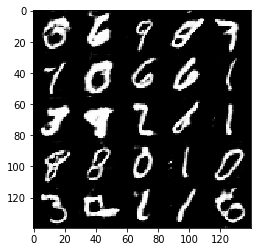

Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.5338
Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 2.2820... Generator Loss: 0.1978
Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 1.5254... Generator Loss: 0.4267
Epoch 2/2... Discriminator Loss: 2.7193... Generator Loss: 0.1034
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 1.8428... Generator Loss: 0.3046
Epoch 2/2... Discriminator Loss: 2.3670... Generator Loss: 0.1847
Epoch 2/2... Discriminator Loss: 1.5487... Generator Loss: 0.4027


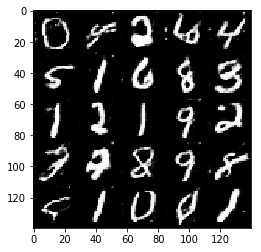

Epoch 2/2... Discriminator Loss: 1.7341... Generator Loss: 0.3010
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.5595
Epoch 2/2... Discriminator Loss: 1.5891... Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 1.0770
Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 1.0453
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 0.9122
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.5802
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.3414
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.4828
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.4960


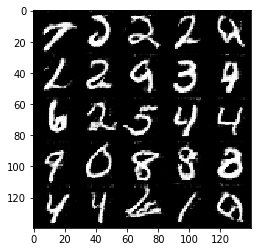

Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.2957
Epoch 2/2... Discriminator Loss: 1.8237... Generator Loss: 0.2905
Epoch 2/2... Discriminator Loss: 1.7206... Generator Loss: 0.3123
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.5070
Epoch 2/2... Discriminator Loss: 0.9005... Generator Loss: 1.3214
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.4938
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.8826
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 0.6675
Epoch 2/2... Discriminator Loss: 0.6269... Generator Loss: 1.6244


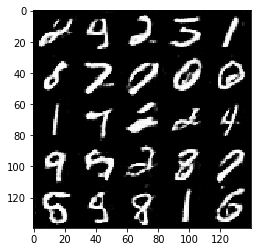

Epoch 2/2... Discriminator Loss: 1.7518... Generator Loss: 0.3226
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 0.9829... Generator Loss: 0.9693
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 0.7321
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 1.0816
Epoch 2/2... Discriminator Loss: 1.8764... Generator Loss: 0.2734
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 1.2911
Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 1.2176
Epoch 2/2... Discriminator Loss: 1.5519... Generator Loss: 0.3914


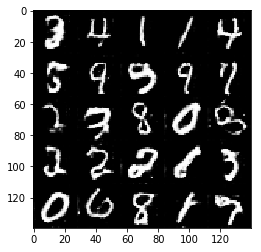

Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 1.0625
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.5737
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 1.6093... Generator Loss: 0.3779
Epoch 2/2... Discriminator Loss: 1.9485... Generator Loss: 0.2561
Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.4237
Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 0.8869


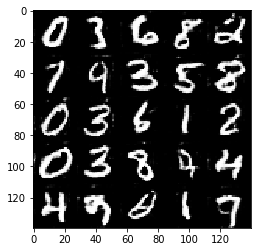

Epoch 2/2... Discriminator Loss: 1.9667... Generator Loss: 0.2365
Epoch 2/2... Discriminator Loss: 1.0577... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 0.6935... Generator Loss: 1.4656
Epoch 2/2... Discriminator Loss: 2.1993... Generator Loss: 0.2156
Epoch 2/2... Discriminator Loss: 0.9401... Generator Loss: 1.7699
Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 1.2976
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.6198
Epoch 2/2... Discriminator Loss: 1.1139... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 0.9921... Generator Loss: 0.9266
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.3168


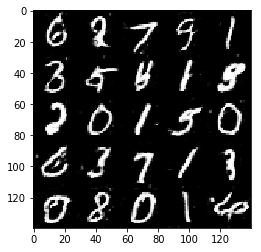

Epoch 2/2... Discriminator Loss: 1.5237... Generator Loss: 0.4526
Epoch 2/2... Discriminator Loss: 1.9114... Generator Loss: 0.2552
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 2.1420... Generator Loss: 0.1991
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.5301
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.4512
Epoch 2/2... Discriminator Loss: 1.7882... Generator Loss: 0.3101
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.6176
Epoch 2/2... Discriminator Loss: 2.9498... Generator Loss: 3.6759


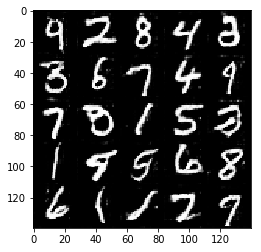

Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 0.8228
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.5439
Epoch 2/2... Discriminator Loss: 2.2667... Generator Loss: 0.2142
Epoch 2/2... Discriminator Loss: 1.8100... Generator Loss: 0.2824
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 1.2666
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 1.4223
Epoch 2/2... Discriminator Loss: 1.5532... Generator Loss: 0.4034
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.8029
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 1.1151


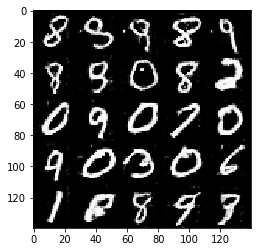

Epoch 2/2... Discriminator Loss: 1.9642... Generator Loss: 0.2418
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.5591
Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.6641... Generator Loss: 0.3368
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 0.9033
Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.4804
Epoch 2/2... Discriminator Loss: 0.8155... Generator Loss: 1.1964
Epoch 2/2... Discriminator Loss: 2.1718... Generator Loss: 0.1941


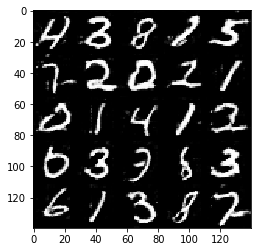

Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 0.9902
Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 0.8926
Epoch 2/2... Discriminator Loss: 1.8693... Generator Loss: 0.2675
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 1.5150
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.5417
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 1.0137
Epoch 2/2... Discriminator Loss: 1.7073... Generator Loss: 0.3269
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.4653... Generator Loss: 0.4178
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.4969


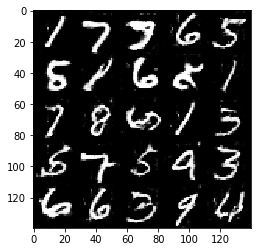

Epoch 2/2... Discriminator Loss: 1.5788... Generator Loss: 0.3797
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 0.4698
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.6734
Epoch 2/2... Discriminator Loss: 1.3711... Generator Loss: 2.3358
Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.3922
Epoch 2/2... Discriminator Loss: 1.7602... Generator Loss: 0.3047
Epoch 2/2... Discriminator Loss: 2.0961... Generator Loss: 0.2345
Epoch 2/2... Discriminator Loss: 0.7675... Generator Loss: 2.6294
Epoch 2/2... Discriminator Loss: 1.5683... Generator Loss: 0.3769


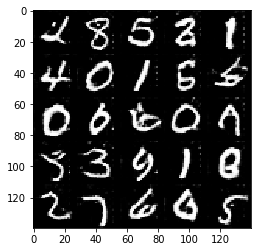

Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 2.2609... Generator Loss: 0.1898
Epoch 2/2... Discriminator Loss: 1.5989... Generator Loss: 0.3709
Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 1.0809
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.9506... Generator Loss: 0.2636
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 2.8054... Generator Loss: 3.7105
Epoch 2/2... Discriminator Loss: 1.0908... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 1.4132... Generator Loss: 0.4810


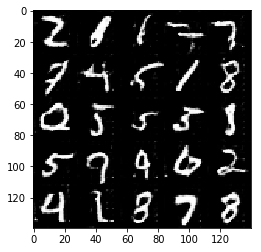

Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 1.0379
Epoch 2/2... Discriminator Loss: 1.8583... Generator Loss: 0.2844
Epoch 2/2... Discriminator Loss: 2.0797... Generator Loss: 0.2539
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 1.0945
Epoch 2/2... Discriminator Loss: 1.7397... Generator Loss: 0.3557
Epoch 2/2... Discriminator Loss: 1.9099... Generator Loss: 0.2442
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.0345
Epoch 2/2... Discriminator Loss: 3.3308... Generator Loss: 0.0702
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 0.9472
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.8195


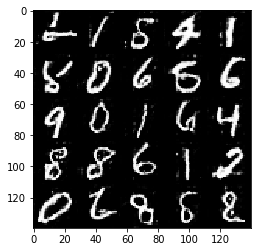

Epoch 2/2... Discriminator Loss: 1.4257... Generator Loss: 0.4435
Epoch 2/2... Discriminator Loss: 1.5733... Generator Loss: 0.3866
Epoch 2/2... Discriminator Loss: 1.8310... Generator Loss: 0.2952
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.4420
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 2.8528


In [15]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.5196... Generator Loss: 0.1296
Epoch 1/1... Discriminator Loss: 2.7029... Generator Loss: 0.1082
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 2.7464... Generator Loss: 0.1078
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 0.6518... Generator Loss: 2.1893
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.8556
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.6007


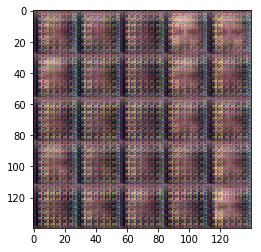

Epoch 1/1... Discriminator Loss: 1.8387... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 1.7107... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 1.9444
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.5565
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.4473
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1210
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.1065


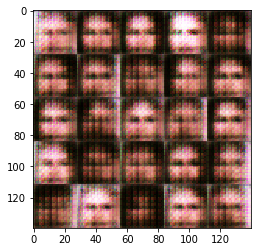

Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.3785
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.5939
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.5101
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 2.0113
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.3940


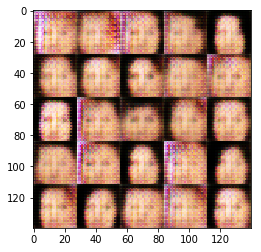

Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 3.5631
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.2753


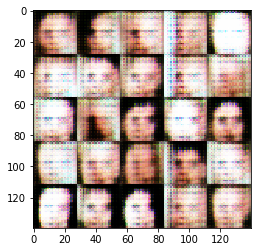

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 2.1076... Generator Loss: 3.4518
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.9601
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.1616
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.8131
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.9899


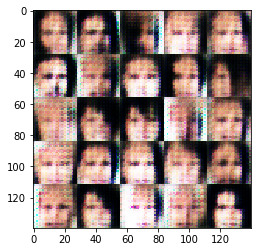

Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.5072
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 2.1505... Generator Loss: 0.2239


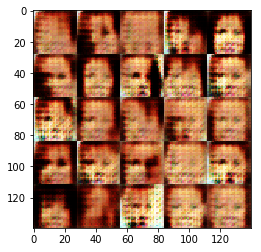

Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 2.0401
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.7430
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.6103
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 1.5602
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.5175


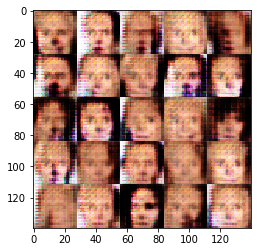

Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.8255... Generator Loss: 3.8707
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 0.6768... Generator Loss: 1.8883
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 2.5164
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.9945


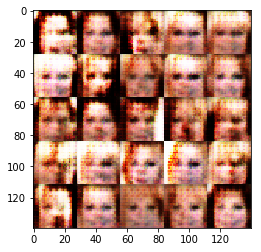

Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 2.1699
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 2.6424
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.2891
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.9307
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 2.4780
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.9453


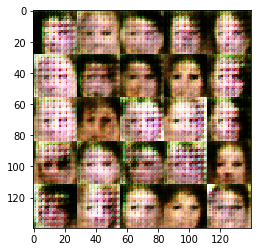

Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.9430... Generator Loss: 0.2610
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 1.6975
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 4.1632


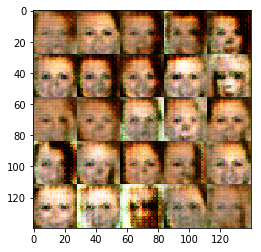

Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 3.1993
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.6051
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 2.2235
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.2496


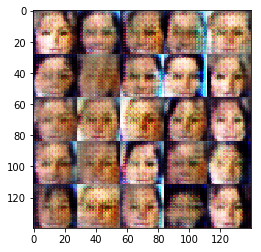

Epoch 1/1... Discriminator Loss: 1.8458... Generator Loss: 0.2956
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 2.8526
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.5365
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 1.0420


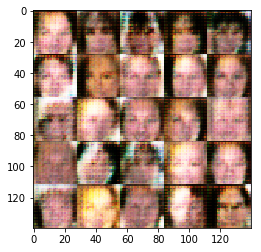

Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.6855
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.9563
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.5658


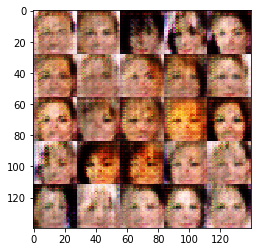

Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.8523
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.6476
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.7901
Epoch 1/1... Discriminator Loss: 1.7311... Generator Loss: 0.3331
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.6156


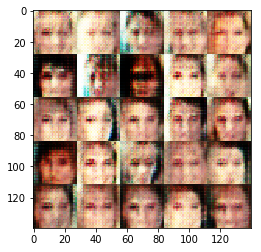

Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.4903
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.7120... Generator Loss: 2.5694
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.1052


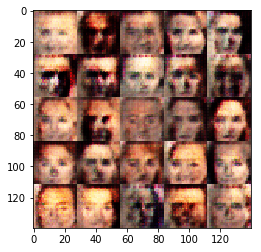

Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.4052
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.5039
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.3687
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 2.0624... Generator Loss: 0.2245
Epoch 1/1... Discriminator Loss: 1.7544... Generator Loss: 0.3026


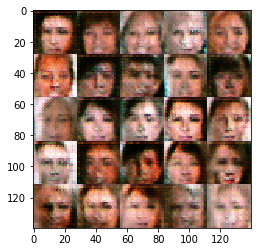

Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.7974... Generator Loss: 0.3366


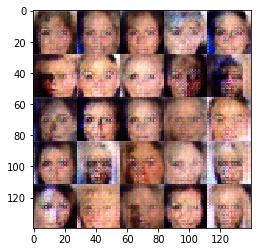

Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.7543
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.4925
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.6961
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.2722
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.3818
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.7748


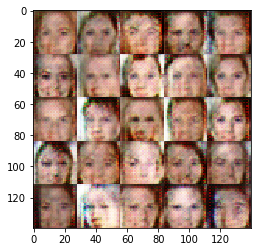

Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 2.4617
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.9265... Generator Loss: 0.2639
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7247


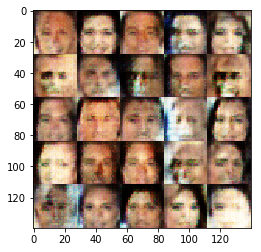

Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.9170
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.2476
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.6321
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.3176


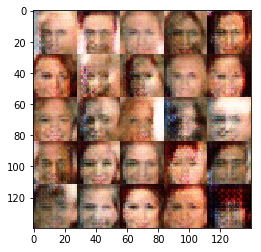

Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 2.3127... Generator Loss: 0.1711
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.5039


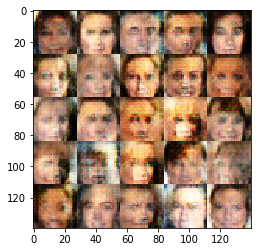

Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 2.3241
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.2535


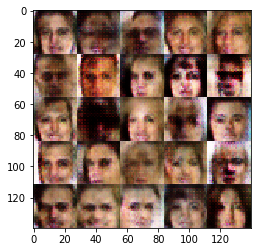

Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.7468
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.6665


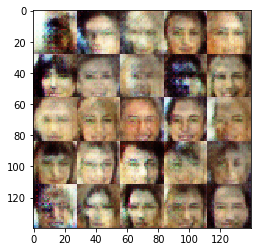

Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.6418
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.2797
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.5546


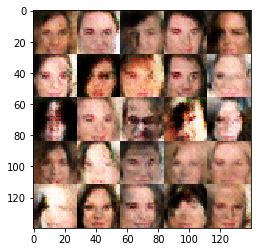

Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.3116
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.2182


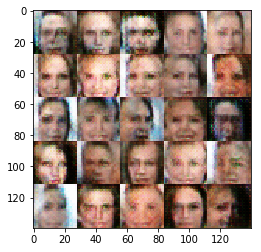

Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 2.1447
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 0.9190


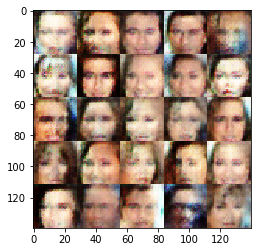

Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.5417
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.9030


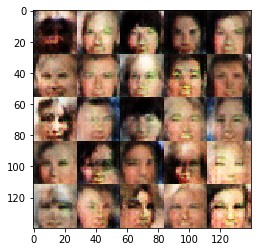

Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.3709


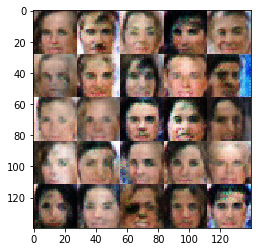

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.8330... Generator Loss: 0.2888
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.5647


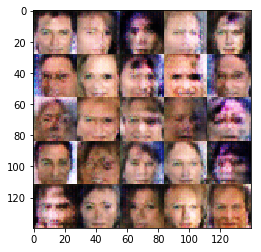

Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.5647
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.2720
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.7365
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.4267
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.9911


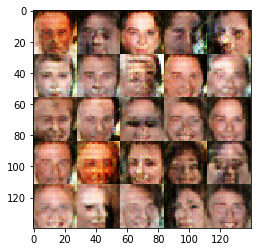

Epoch 1/1... Discriminator Loss: 1.6948... Generator Loss: 0.3384
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.5426
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.7641


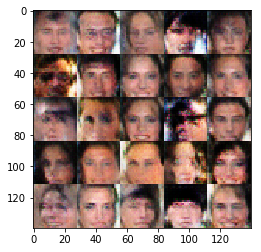

Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.8208


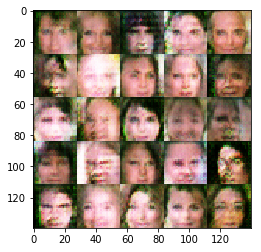

Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 1.7731
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.2663
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.7041


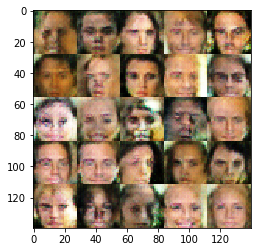

Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.7393
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.6645... Generator Loss: 0.3508


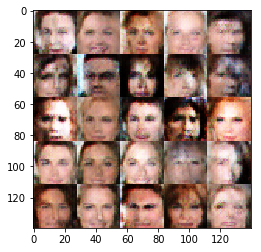

Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.5382
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.5654
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.0167


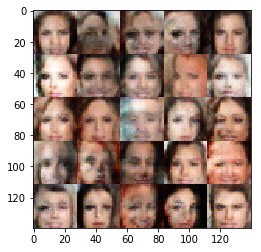

Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.3076


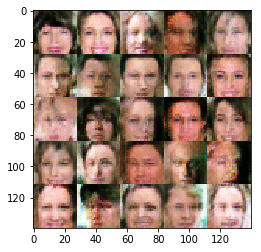

Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 2.6068
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.3373


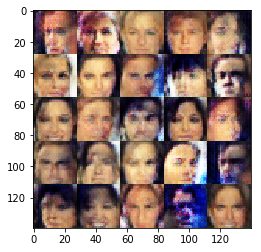

Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.3148


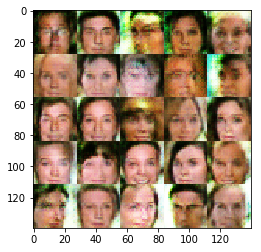

Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.9676


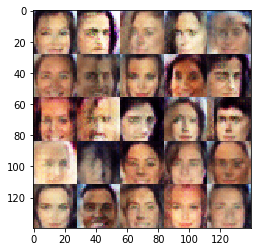

Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.5560


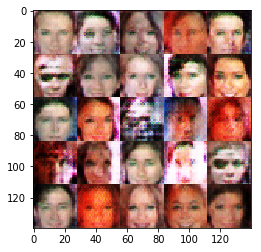

Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.6171


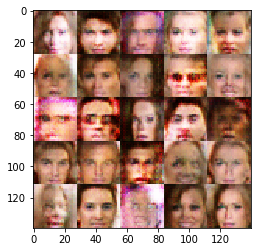

Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.2843


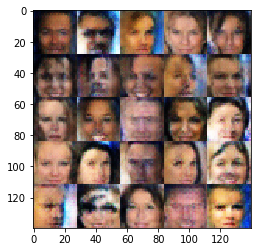

Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 0.4192
Epoch 1/1... Discriminator Loss: 1.6350... Generator Loss: 0.3722
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.6286
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.7971


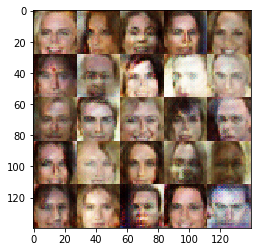

Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.0067
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 1.7972
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.2722
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.3725
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 1.1349


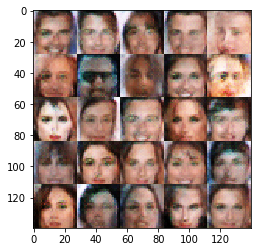

Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.6416
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.9231


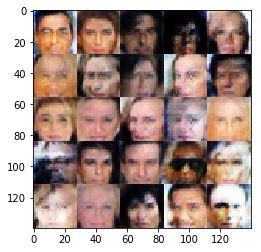

Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 1.6608... Generator Loss: 0.4049
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.9138


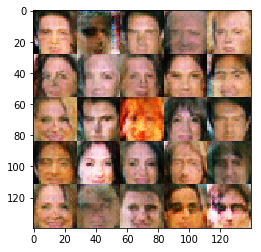

Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.8760


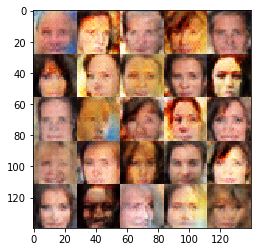

Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.3136
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6943


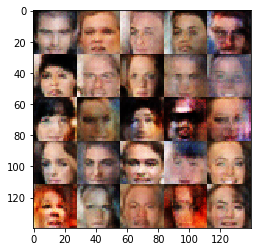

Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.5964


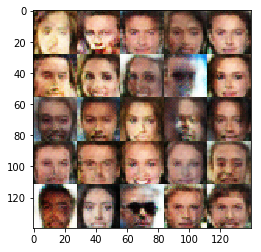

Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.4886


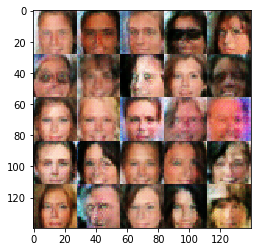

Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.0247


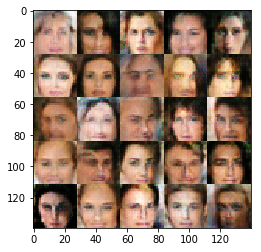

Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.4315
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.0219


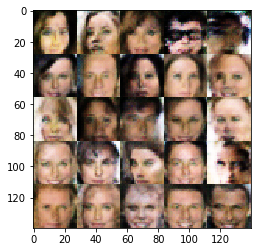

Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.9283


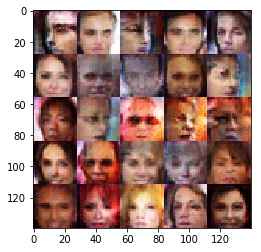

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.6724


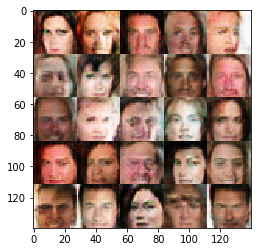

Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.2907


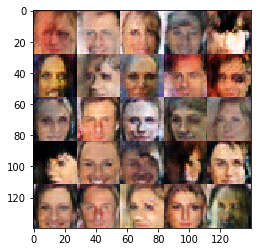

Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.6480


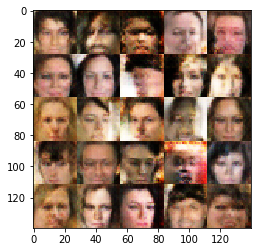

Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.8274


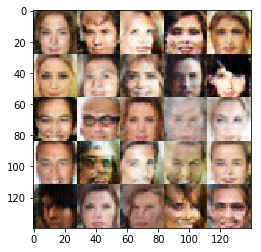

Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.6466


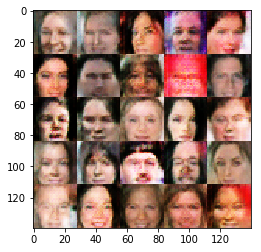

Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.5858


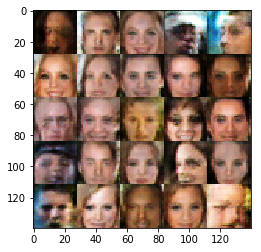

Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.8484


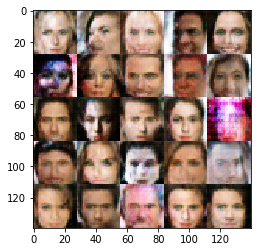

Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8854


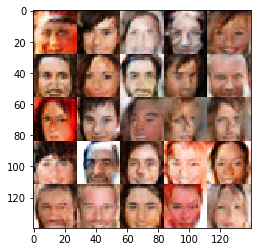

Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.6028


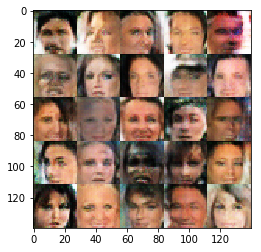

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.5933


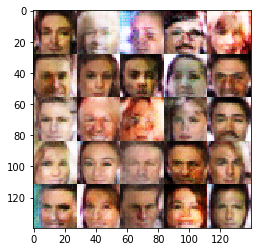

Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.0829


In [16]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.